# Figure 4 Final

Notebook to make data for figure 4 for ms <br>
by Cascade Tuholske 2020.02.23

In [1]:
#### Depdencies 
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

In [ ]:
#### Functions
def OLS(df, geog, col, alpha):
    
    """Finds linear coef for increase in stat by a given geography from 1983 - 2016, as well
    as the pct change in population of the cities within the given geography
    
    NOTE 2020.03.01 - This will throw a run time warning if all values of a col are zero (e.g. can regress
    a bunch of zeros) ... See note in run_OLD. CPT 
    
    NOTE 2020.03.01 - Later in the day this issue is resolved by removing the offending cities. See comments
    in code. CPT
    
    
    Args:
        df = HI stats dataframe
        geog = subset geography to calc people days regression
        col = col to regress on 
        alpha = ci alpha for coef
    """

    # Get results
    labels = []
    #delt_list = [] #CPT 2020.02.26
    #r2_list = [] #CPT 2020.02.26
    coef_list = []
    leftci_list = []
    rightci_list = []
    p_list = []
    df_out = pd.DataFrame()

    for label, df_geog in df.groupby(geog):

        # Get Data
        X_year = np.array(df_geog.groupby('year')['ID_HDC_G0'].mean().index).reshape((-1, 1))
        Y_stats = np.array(df_geog.groupby('year')[col].sum()).reshape((-1, 1))

        # Add Intercept
        X_year_2 = sm.add_constant(X_year)

        # Regress
        model = sm.OLS(Y_stats, X_year_2).fit() 
        
        # Get slope
        # first param in intercept coef, second is slope of line but if slope = 0, then intecept
        if len(model.params) == 2:
            coef = model.params[1]
            
        else:
            coef = model.params[0]
        
        # R2 and P
        #r2 = model.rsquared_adj #CPT 2020.02.26
        p = model.pvalues[0]

        # Pop change #CPT 2020.02.26
#         delt = df_geog.drop_duplicates('ID_HDC_G0').copy()
#         delt['delt_pop'] = delt['P2016'] - delt['P1983']
#         delt = delt['delt_pop'].sum()

        # GET Left and Right CI
        left_ci = model.conf_int(alpha=alpha)[1][0]
        right_ci = model.conf_int(alpha=alpha)[1][1]
        
        # Make lists
        labels.append(label)
        #r2_list.append(r2) #CPT 2020.02.26
        coef_list.append(coef)
        p_list.append(p)
        leftci_list.append(left_ci)
        rightci_list.append(right_ci)
        #delt_list.append(delt) #CPT 2020.02.26

    # Make data frame
    df_out[geog] = labels
    #df_out['p_delt'] = delt_list #CPT 2020.02.26
    #df_out['r2'] = r2_list #CPT 2020.02.26
    df_out['coef'] = coef_list
    df_out['p_value'] = [round(elem, 4) for elem in p_list]
    df_out['ci_left'] = leftci_list
    df_out['ci_right'] = rightci_list 

    return df_out


In [ ]:
def run_OLS(stats, geog, alpha):
    """ Function calculate OLS coef of people days due to pop and heat and the 
    attribution index for distribution plots.
    
        
    NOTE 2020.03.01 - This will throw a run time warning if all values of a col are zero (e.g. can regress
    a bunch of zeros, now can we). This will happen if people_days, people_days_pop, people_days_heat or 
    total_days is zero for all years for a given city. This is still OK for our analysis. What is happening is
    that for some cities, the people-days due to heat is zero, meaning pday increases in only due to population. 
    
    This is because with the GHS-UCDB some city's population in 1983 is zero, which forces the pdays due to heat
    to be zero.
    
    NOTE 2020.03.01 - Later in the day this issue is resolved by removing the offending cities. See comments
    in code.
    
    -- CPT  
    
    Args:
        stats = df to feed in
        geog = geography level to conduct analysis (city-level is 'ID-HDC-G0')
        alpha = alpha for CI coef   
    """
    # Get coef for people days
    out = OLS(stats, geog, 'people_days', alpha = alpha)
    out.rename(columns={"coef": "coef_pdays"}, inplace = True)
    out.rename(columns={"p_value": "p_value_pdays"}, inplace = True)
    out.rename(columns={"ci_left": "ci_left_pdays"}, inplace = True)
    out.rename(columns={"ci_right": "ci_right_pdays"}, inplace = True)
    
    # Get people days due to heat coef
    heat = OLS(stats, geog, 'people_days_heat', alpha = alpha) # get stats 
    heat.rename(columns={"coef": "coef_heat"}, inplace = True)
    heat.rename(columns={"p_value": "p_value_heat"}, inplace = True)
    heat.rename(columns={"ci_left": "ci_left_heat"}, inplace = True)
    heat.rename(columns={"ci_right": "ci_right_heat"}, inplace = True)
    out = out.merge(heat, on = geog, how = 'left') # merge
    
    # Get people days due to pop
    pop = OLS(stats, geog, 'people_days_pop', alpha = alpha) # get stats 
    pop.rename(columns={"coef": "coef_pop"}, inplace = True)
    pop.rename(columns={"p_value": "p_value_pop"}, inplace = True)
    pop.rename(columns={"ci_left": "ci_left_pop"}, inplace = True)
    pop.rename(columns={"ci_right": "ci_right_pop"}, inplace = True)
    out = out.merge(pop, on = geog, how = 'left') # merge
    
    # Get total days
    totDays = OLS(stats, geog, 'total_days', alpha = alpha) # get stats 
    totDays.rename(columns={"coef": "coef_totDays"}, inplace = True)
    totDays.rename(columns={"p_value": "p_value_totDays"}, inplace = True)
    totDays.rename(columns={"ci_left": "ci_left_totDays"}, inplace = True)
    totDays.rename(columns={"ci_right": "ci_right_totDays"}, inplace = True)
    out = out.merge(totDays, on = geog, how = 'left') # merge
    
    # attrib coef --- creates range -1 to 1 index of heat vs. population as a driver of total pdays increase
    out['coef_attrib'] = (out['coef_pop'] - out['coef_heat']) / (out['coef_pop'] + out['coef_heat']) # normalize dif
    
    # I am not sure if this works correcetly ... CPT 2020.02.27
    out['coef_attrib_left'] = (out['ci_left_pop'] - out['ci_left_heat']) / (out['ci_left_pop'] + out['ci_left_heat']) # normalize dif
    out['coef_attrib_right'] = (out['ci_right_pop'] - out['ci_right_heat']) / (out['ci_right_pop'] + out['ci_left_heat']) # normalize dif
    
    # drop all neg or zero pday slopes
    out = out[out['coef_pdays'] > 0]
    out = out[out['coef_heat'] > 0]
    out = out[out['coef_pop'] > 0]
    
    # normalize coef of attribution 
    norm = out['coef_attrib']
    out['coef_attrib_norm'] = (norm-min(norm))/(max(norm)-min(norm))
    norm = out['coef_attrib_left']
    out['coef_attrib_norm_left'] = (norm-min(norm))/(max(norm)-min(norm))
    norm = out['coef_attrib_right']
    out['coef_attrib_norm_right'] = (norm-min(norm))/(max(norm)-min(norm))
    
    return out

In [ ]:
#### Regressions, no intercept addition is needed because we're using SK LEARN HERE 

def lm_func(df, col, scale):
    
    "simple linear model of a time series data, returns coef"
    
    # Get Data
    X_year = np.array(df.groupby('year')['ID_HDC_G0'].mean().index).reshape((-1, 1))
    Y_stats = np.array(df.groupby('year')[col].sum()).reshape((-1, 1))

    # Add Intercept
    X_year_2 = sm.add_constant(X_year)

    # Regress
    model = sm.OLS(Y_stats, X_year_2).fit() 
        
    coef = int(model.params[1]*scale)
    #coef = int(coef)
            
    # R2 and P
    r2 = model.rsquared_adj
    p = model.pvalues[0]
    
    return coef, round(r2, 2), round(p, 3)

In [2]:
#### Load Data
# file path
DATA_IN = "/home/cascade/projects/UrbanHeat/data/"  # Note: Need ?dl=1 to make sure this file gets read correctly
FIG_OUT = "/home/cascade/projects/UrbanHeat/figures/"

# HI DATA
FN_IN = 'processed/AllDATA-GHS-ERA5-HI406-FIGDATA.csv'
HI_STATS = pd.read_csv(DATA_IN+FN_IN)

FN_IN = 'processed/AllDATA-GHS-ERA5-HI406-MAPDATA.csv'
MAP_DATA = pd.read_csv(DATA_IN+FN_IN)


# scale the date in the plot 
scale = 10**9 

In [3]:
#### Drop cities where P1983 == 0
print(len(HI_STATS))
HI_STATS = HI_STATS[HI_STATS['P1983'] > 0]
print(len(HI_STATS))

#### Drop cities with only one Tmax Day in 1983 and none else because you cannot regress them
#drop_list = [2543, 2560, 3667, 3669, 6122, 6156] # city ids for MERRA2 
drop_list = [832, 1732, 5521] # city IDS for ERA5

HI_STATS= HI_STATS[~HI_STATS['ID_HDC_G0'].isin(drop_list)]
print(len(HI_STATS))

386920
385526
385424


In [4]:
HI_STATS.head()

,Unnamed: 0,ID_HDC_G0,year,total_days,P,P1983,P2016,people_days,people_days_heat,people_days_pop
0,0,5645,1983,1,80796.793810,80796.79381,96123.248169,80796.793810,80796.79381,0.000000
1,1,5645,1989,2,78918.494262,80796.79381,96123.248169,157836.988523,161593.58762,-3756.599097
2,2,5645,1990,3,78605.444337,80796.79381,96123.248169,235816.333011,242390.38143,-6574.048420
3,3,5645,1994,1,76481.266889,80796.79381,96123.248169,76481.266889,80796.79381,-4315.526921
4,4,5645,2005,1,80904.416534,80796.79381,96123.248169,80904.416534,80796.79381,107.622724


In [5]:
## Add In Meta Data
geog = ['region', 'intermediate-region', 'sub-region','CTR_MN_NM', 'ID_HDC_G0', 'GCPNT_LAT', 'GCPNT_LON']
meta_fn = 'processed/AllDATA-GHS-ERA5-HI406-META.csv'
all_data = pd.read_csv(DATA_IN+meta_fn)
meta = all_data[geog]
meta = meta.drop_duplicates('ID_HDC_G0')

## Merge in meta
HI_STATS = HI_STATS.merge(meta, on = 'ID_HDC_G0', how = 'left')

In [6]:
#### Select a city in India
data = HI_STATS[HI_STATS['ID_HDC_G0'] == 6334]

In [7]:
X = data.sort_values('year')['year']
Y = data.sort_values('year')['total_days']

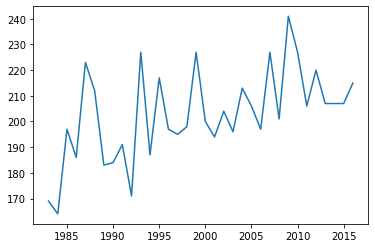

In [8]:
plt.plot(X,Y)

(array([3., 0., 4., 2., 8., 6., 4., 2., 4., 1.]),
 array([164. , 171.7, 179.4, 187.1, 194.8, 202.5, 210.2, 217.9, 225.6,
        233.3, 241. ]),
 <a list of 10 Patch objects>)

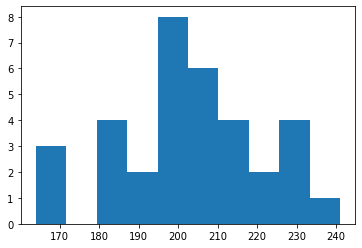

In [9]:
plt.hist(Y)

In [10]:
mean = np.mean(Y)
SD = np.std(Y)
zscores = (Y - mean)/SD

In [11]:
#### calculate Z scores for each value
def z_score(data):
    "mini function to make z scoares"
    mean = np.mean(data)
    sd = np.std(data)
    zscores = (data - mean) / sd
    
    return zscores

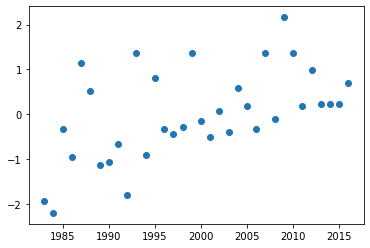

In [12]:
plt.scatter(X, zscores)

In [75]:
#### Let's plot the zscores for each city in India
country = 'Nigeria'
data = HI_STATS[HI_STATS['CTR_MN_NM'] == country]

In [76]:
years = list(np.unique(data.sort_values('year')['year']))
cols = ['ID_HDC_G0']+years
zscores_df = pd.DataFrame(columns = cols)

In [77]:
years_list = []
zscores_list = []

years = list(np.unique(data.sort_values('year')['year']))

for i, city_df in enumerate(data.groupby('ID_HDC_G0')):
    total_days = list(city_df[1].sort_values('year')['total_days'].values)
    zscores = z_score(total_days) 
    zscores_list.append(zscores)
    years_list.append(years)


Text(0, 0.5, 'z-score')

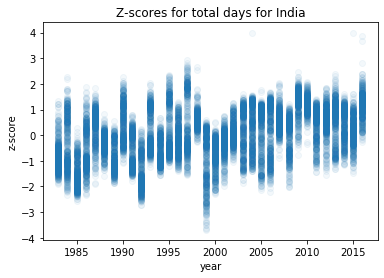

In [78]:
plt.scatter(years_list, zscores_list, alpha = 0.05)
plt.title('Z-scores for total days for India')
plt.xlabel('year')
plt.ylabel('z-score')

# Find Residuals for Total Days Trends

In [86]:
coef_totdays = pd.read_csv(DATA_IN+'processed/AllDATA-GHS-ERA5-HI406-MAPDATA_TOTDAYS_P05.csv')
coef_totdays.columns

Index(['Unnamed: 0', 'ID_HDC_G0', 'coef_pdays', 'p_value_pdays',
       'ci_left_pdays', 'ci_right_pdays', 'coef_heat', 'p_value_heat',
       'ci_left_heat', 'ci_right_heat', 'coef_pop', 'p_value_pop',
       'ci_left_pop', 'ci_right_pop', 'coef_totDays', 'p_value_totDays',
       'ci_left_totDays', 'ci_right_totDays', 'coef_attrib',
       'coef_attrib_left', 'coef_attrib_right', 'coef_attrib_norm',
       'coef_attrib_norm_left', 'coef_attrib_norm_right', 'region',
       'intermediate-region', 'sub-region', 'CTR_MN_NM', 'GCPNT_LAT',
       'GCPNT_LON', 'P1983', 'P2016'],
      dtype='object')

In [87]:
data = coef_totdays[coef_totdays['CTR_MN_NM'] == 'India'][['ID_HDC_G0','coef_totDays']]

In [88]:
data

,ID_HDC_G0,coef_totDays
2441,6334,0.961650
2464,6364,1.176623
2468,6369,0.836516
2479,6385,0.971429
2488,6396,1.113522
...,...,...
5773,10094,1.122842
5774,10095,1.305730
5775,10099,1.265393
5777,10101,1.233919


In [102]:
#### Select a city in India
city = HI_STATS[HI_STATS['ID_HDC_G0'] == 6334]
slope = data[data['ID_HDC_G0'] == 6334]['coef_totDays'].values[0]

In [108]:
city = city[['year', 'total_days']]
city['trend'] = city['total_days'] * slope
city['residual'] = city['total_days'] - city['trend']

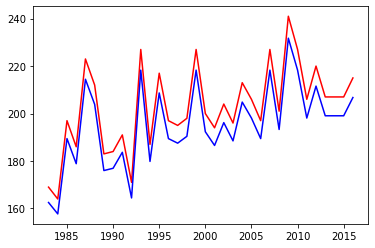

In [111]:
plt.plot(city['year'], city['total_days'], color = 'red')
plt.plot(city['year'], city['trend'], color = 'blue')


(array([3., 0., 4., 2., 8., 6., 4., 2., 4., 1.]),
 array([6.28938121, 6.58467532, 6.87996944, 7.17526356, 7.47055768,
        7.7658518 , 8.06114591, 8.35644003, 8.65173415, 8.94702827,
        9.24232238]),
 <a list of 10 Patch objects>)

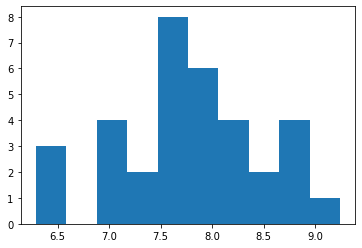

In [112]:
plt.hist(city['residual'])

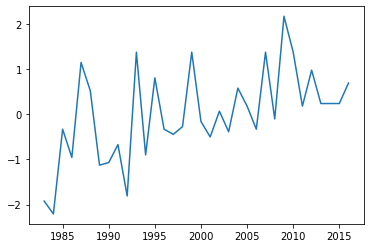

In [114]:
plt.plot(sorted(city['year']), z_score(city['residual']))

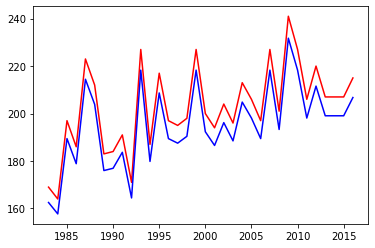

In [115]:
plt.plot(city['year'], city['total_days'], color = 'red')
plt.plot(city['year'], city['trend'], color = 'blue')



# Old Code

In [72]:
# Make an empty data frame
years = list(np.unique(data.sort_values('year')['year']))
#cols = ['ID_HDC_G0']+years
cols = years
zscores_df = pd.DataFrame(columns = cols)

for i, city_df in enumerate(data.groupby('ID_HDC_G0')):
    row = []
#    city_id = city_df[0]
#    row.append(city_id) # get the city ids
    total_days = list(city_df[1].sort_values('year')['total_days'].values)
    zscores = z_score(total_days) 
    row = row + list(zscores) # tag on the z-scores
    row = pd.Series(row, index = zscores_df.columns)
    
    # append the df
    zscores_df = zscores_df.append(row, ignore_index=True)

In [ ]:
#### Select a Country

country = 'India'
data = HI_STATS[HI_STATS['CTR_MN_NM'] == country]
#data = HI_STATS[HI_STATS['ID_HDC_G0'] == 6334]

In [ ]:
X = data.sort_values('year')['year']
Y = data.sort_values('year')['total_days']

In [ ]:
data.head()

In [ ]:
#### Select a Country
country = 'China'
data = HI_STATS[HI_STATS['CTR_MN_NM'] == country]

fig, axs = plt.subplots(1, 1, figsize = (7, 5), sharex=True)
line_kws = {'linestyle' : '-', 'linewidth' : 3, 'alpha' : 0.7}


for label, city in data.groupby('ID_HDC_G0'):
    X = city.sort_values('year')['year']
    Y = city.sort_values('year')['total_days']
    
    # set alphas 
    
    plt.plot(X,Y, alpha = 0.05, color = 'gray') #'lavender')

X = data.sort_values('year')['year']
Y = data.sort_values('year')['total_days']
sns.regplot(X, Y, color = 'purple', scatter = False, truncate = True, line_kws = line_kws)

#### Select a Country
# country = 'Indonesia'
# data = HI_STATS[HI_STATS['CTR_MN_NM'] == country]
# X = data.sort_values('year')['year']
# Y = data.sort_values('year')['total_days']

# for label, city in data.groupby('ID_HDC_G0'):
#     X = city.sort_values('year')['year']
#     Y = city.sort_values('year')['total_days']
    
#     plt.plot(X,Y, alpha = 0.05, color = 'palegreen')
    
# X = data.sort_values('year')['year']
# Y = data.sort_values('year')['total_days']
# sns.regplot(X, Y, color = 'darkgreen', scatter = False, truncate = True, line_kws = line_kws, label = 'Egypt')
    
#plt.ylim([0,25])#### Select a Country
plt.title(country+' Total Days per Year HI > 40.6 C')
plt.ylabel('Days/yr HI > 40.6')

In [ ]:
#### Select a Country
fig, axs = plt.subplots(1, 1, figsize = (7, 5), sharex=True)
line_kws = {'linestyle' : ':'}

country = 'India'
data = HI_STATS[HI_STATS['CTR_MN_NM'] == country]
X = data['year']
Y = data['total_days']

plt.scatter(X,Y, alpha = 0.002)#, s = 20, marker = '.')
sns.regplot(X, Y, color = 'purple', scatter = False, truncate = True, line_kws = line_kws)
#plt.ylim([0,1])

In [ ]:
len(np.unique(data['ID_HDC_G0']))

# Check Total Days > 365

In [ ]:
#### Select a Country
country = 'Indonesia'
data = HI_STATS[HI_STATS['CTR_MN_NM'] == country]

In [ ]:
data[data['total_days']> 365]

In [ ]:
alldata = pd.read_csv(DATA_IN+'processed/All_data_HI406_meta.csv')

In [ ]:
alldata.head()

In [ ]:
list(alldata[(alldata['year'] == 1997) & (alldata['ID_HDC_G0'] == 11423)]['event_dates'])